In [1]:
# Tang Kit Lim (WQD190032)

import numpy as np 
import pandas as pd
import datetime
from pathlib import Path
from geopy.distance import distance

In [2]:
# load data from csv

data_directory = '../data/processed/'
Path(data_directory).mkdir(parents=True, exist_ok=True)

processed_transaction_csv = data_directory + 'edgeprop_transactions_processed.csv'
# transaction_csv = data_directory + 'edgeprop_transactions_processed.csv'

transactions = pd.read_csv(processed_transaction_csv, na_values=['None'], index_col=0)


## Data preparation for Model Training 

In [3]:
# reduce set to only klang valley after year 2017
transactions = transactions[
#     (
#         (transactions['state'] == 'Kuala Lumpur') | 
#         (transactions['state'] == 'Selangor') | 
#         (transactions['state'] == 'Putrajaya')
#     ) 
#     & 
    (transactions['year'] >= 2017)
]

transactions['non_landed'] = transactions['non_landed'].astype('category')

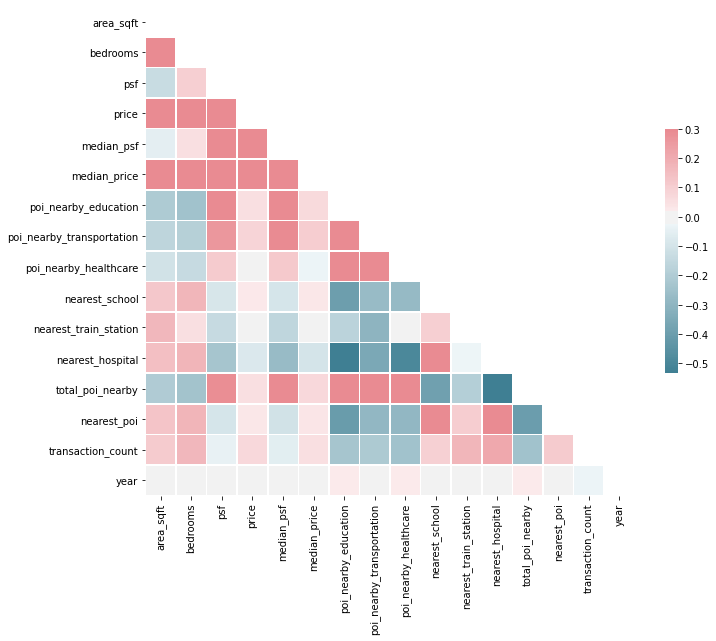

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = transactions.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Feature Selections (Repeating)

In [5]:
# after rounds of evaluating the models, drop features with collinearity
# although including all features achieved highest accuracy predicting the testing set
# but advantages are not marginal and those informtion is hard for user input
numerical_features = [
    'area_sqft', 'bedrooms', 'nearest_poi'
    # 'poi_nearby_education','poi_nearby_transportation','poi_nearby_healthcare',
    # 'nearest_school', 'nearest_train_station', 'nearest_hospital', 'total_poi_nearby',
]

categorical_features = [
    'city', 'property_type', 'tenure', 'state' #, 'non_landed', 'planning_region'
]

features = numerical_features + categorical_features
target = 'price'

transactions = transactions[features + [target]]

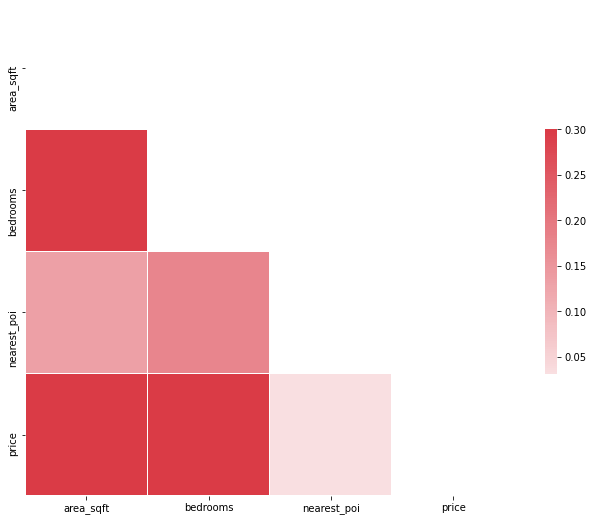

In [6]:
# correlation heatmap for the selected (numerical) features only
corr = transactions.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Model Training & Evaluation (Repeating)

In [7]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [8]:
x = transactions[features]
y = transactions[target]

column_transform = make_column_transformer(
    (MinMaxScaler(), numerical_features),
    (OneHotEncoder(), categorical_features),
    remainder='passthrough'
)

column_transform.fit_transform(x)

preprocess = make_pipeline(
    column_transform
)
preprocess.fit_transform(x)

linear_regression = LinearRegression()


In [9]:
pipeline = make_pipeline(preprocess, linear_regression)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 17)

In [11]:
pipeline.fit(x, y)
print("Score: %f" % pipeline.score(x_test, y_test))

pd.DataFrame({
    'predicted_price': y_test,
    'price': pipeline.predict(x_test)
})

Score: 0.652936


,predicted_price,price
138911,470000,285376.957950
70790,215000,278312.810065
200620,300000,372314.116381
108388,280000,316306.883991
142419,475000,550303.920822
...,...,...
178699,450000,585244.245548
38443,400000,337012.046933
82652,745000,746443.875724
110332,420000,328251.820281


In [12]:
from pickle import dump
dump(pipeline, open('../data/model.pkl', 'wb'))


In [13]:
x_test

,area_sqft,bedrooms,nearest_poi,city,property_type,tenure,state
138911,1023.0,3.0,237.080618,Bandar Tun Razak,Condominium/Apartment,Leasehold,Kuala Lumpur
70790,689.0,3.0,430.445153,Ayer Itam,Flat,Freehold,Penang
200620,1442.0,3.0,91.876882,Klang,Terrace House,Freehold,Selangor
108388,1604.0,3.0,691.504852,Kuala Selangor,Terrace House,Freehold,Selangor
142419,1981.0,3.0,748.991321,Shah Alam,Town House,Leasehold,Selangor
...,...,...,...,...,...,...,...
178699,1270.0,3.0,528.259665,Wangsa Maju,Condominium/Apartment,Freehold,Kuala Lumpur
38443,840.0,3.0,527.907853,Seri Kembangan,Town House,Freehold,Selangor
82652,1798.0,3.0,364.561082,Subang Jaya,Terrace House,Freehold,Selangor
110332,872.0,2.0,112.256317,Petaling Jaya,Condominium/Apartment,Leasehold,Selangor
